#Part I: Decision Stump By Hand

##1.1 Get the data

In [ ]:
import os, sys
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/intro_ml/

/content/gdrive/MyDrive/intro_ml


In [ ]:
data_path = "/content/gdrive/MyDrive/intro_ml/"
data_file = "ATLAS_higgs_train.csv"

### 1.1.1 Explore

In [ ]:
df = pd.read_csv(data_file)
df.head()

,Z1mass,Z2mass,detajj,massjj,l1pdgid,l1eta,l1phi,l1pt,l2pdgid,l2eta,...,l2pt,l3pdgid,l3eta,l3phi,l3pt,l4pdgid,l4eta,l4phi,l4pt,sample
0,68.515258,57.174385,4.283580,556.406882,-11,0.490221,-2.302279,68.776711,-11,0.910430,...,50.775758,11,-0.495413,-1.409834,28.700672,11,0.542029,-0.328558,17.054512,1
1,84.330551,25.551337,1.101106,266.768190,-11,1.291437,1.917571,77.658719,11,0.142028,...,61.922754,-13,0.208367,1.411837,30.645279,13,1.380638,0.300915,8.034711,-1
2,90.902327,30.404745,2.394863,211.879331,-13,0.702544,-0.946013,91.046750,13,0.958006,...,32.417166,11,0.385190,0.934649,17.942230,-11,0.672241,-1.410558,14.799019,-1
3,91.129112,26.609989,1.040268,56.235126,-11,-2.450392,3.123466,58.988305,11,-1.276226,...,30.001736,-13,-1.275654,0.280533,12.816265,13,-2.283192,-2.326921,11.448904,1
4,87.525977,32.304742,3.674720,351.241850,11,-1.303559,0.963711,66.502133,-11,-0.254885,...,26.519908,-13,-1.052104,0.041387,22.981393,13,0.099710,1.758643,12.038583,1


Tasks:

In [ ]:
print("The number of events the file contains :", df.shape[0])
print("The number of VBF processes the file contains : ",len(df[df["sample"]==1]))
print("The number of ggF processes the file contains : ",len(df[df["sample"]== -1]))


The number of events the file contains : 35000
The number of VBF processes the file contains :  17500
The number of ggF processes the file contains :  17500


###1.1.2 Visualize the Training Data


In [ ]:
# Variables of interest
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'

inputs = [XNAME, YNAME]

# Binning ranges
XBINS, XMIN, XMAX, XSTEP = 5, 0, 5, 1
YBINS, YMIN, YMAX, YSTEP = 5, 0, 1000, 200

# Split training data into signal and background
# Create a DataFrame 'sig' for signal events (sample == 1) within the defined ranges.
sig = df.loc[(df['sample']== 1) & (df[XNAME] >= XMIN) & (df[XNAME]<= XMAX) & (df[YNAME] >= YMIN) & (df[YNAME]<= YMAX) ]
# Create a DataFrame 'bkg' for background events (sample == -1) within the defined ranges.
bkg = df.loc[(df['sample']== -1) & (df[XNAME] >= XMIN) & (df[XNAME]<= XMAX) & (df[YNAME] >= YMIN) & (df[YNAME]<= YMAX)]
print("sig", sig.shape)
print("bkg", bkg.shape)

sig (17222, 21)
bkg (17460, 21)


In [ ]:
import matplotlib.pyplot as plt

FONTSIZE = 16
params = {
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE,
         'xtick.labelsize':FONTSIZE,
         'ytick.labelsize':FONTSIZE,
         'legend.fontsize':FONTSIZE}
plt.rcParams.update(params)

In [ ]:
def plot_scatter(sig, bkg,
              xname=XNAME, xlabel=XLABEL, xmin=XMIN, xmax=XMAX, xstep=XSTEP,
              yname=YNAME, ylabel=YLABEL, ymin=YMIN, ymax=YMAX, ystep=YSTEP,
              fgsize=(6, 6), ftsize=FONTSIZE, alpha=0.3, title="Scatter plot"):

  fig, ax = plt.subplots(figsize=fgsize)

  # Annotate x-axis
  ax.set_xlim(xmin, xmax)
  ax.set_xlabel(xlabel)
  ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))

  # Annotate y-axis
  ax.set_ylim(ymin, ymax)
  ax.set_ylabel(ylabel)
  ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=8, c='b', alpha=alpha, label='VBF')
  ax.scatter(bkg[xname], bkg[yname], marker='*', s=8, c='r', alpha=alpha, label='ggf')

  # Legend and plot:
  ax.legend(fontsize=ftsize, bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title, pad=20)
  plt.show()

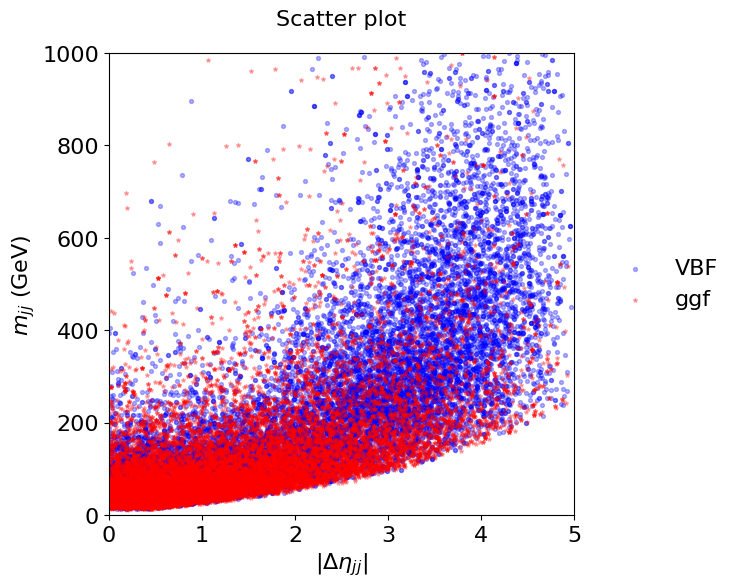

In [ ]:
plot_scatter(sig,bkg)

### 1.1.3 Prepare Dataset (Features & Labels)

In [ ]:
# Extract detajj & massjj and convert to NumPy
X_train = df[['detajj','massjj']].to_numpy()
y_train = df[['sample']].to_numpy()
print(X_train.shape)
print(y_train.shape)

(35000, 2)
(35000, 1)


## 1.2 Compute the Gini Index

In [ ]:
def get_gini_index(y, classes):
    """
    y       : NumPy array of labels in the node
    classes : list of possible class values (e.g., [-1, 1])
    """

    # Total number of samples in the node
    N_i= y.shape[0]

    # Count the number of samples for each class.
    # The comparison y == classes.T broadcasts to create a boolean array of shape (n_samples, n_classes).
    # np.sum with axis=0 sums over the samples, resulting in counts for each class, shape (1, n_classes).
    N_ki= np.sum(y== classes.T, axis=0).reshape(-1,1)

    # If the node is empty, the Gini index is 0 (to avoid dividing by zero).
    if N_i == 0:
      return 0

    gini= 1- np.sum((N_ki/N_i) **2).item()

    return gini

## 1.3 Compute the Cost Function

In [ ]:
def get_cost(n_left, gini_left, n_right, gini_right):
    """
        n_left: Number of samples in the left node
        n_right: Number of samples in the right node
        gini_left: Gini index of the left node
        gini_right: Gini index of the right node

    """

    # ... your code here
    # Total number of samples in the parent node
    n_node= n_left + n_right
    # Calculate the weighted average of the Gini indices of the child nodes
    J= (n_left/n_node)* gini_left + (n_right/n_node)* gini_right

    return J


##1.4 Decision Stump: Core of the Action

In [ ]:
def get_threshold_min_cost(feature_values, y, classes, precision=0.01):
    """
    Find the threshold that minimizes the weighted Gini index.

    Parameters
    ----------
    feature_values: NumPy array of feature values, shape (n_samples, n_features)
    y:              NumPy array of labels, shape (n_samples, 1)
    classes:        list of possible class values
    precision:      The step size for checking thresholds as a fraction of the feature's range.

    Returns
    -------
    A list containing: [feature_index, best_threshold, min_cost]

    """

    # ... your code here
    # Initialize with a very high cost
    x_cost = [0, 0, float('inf')]

    # To keep track of the feature index (1-based)
    count=0

    # feature_values.T transposes the array to iterate over columns (features).
    for x in feature_values.T:
      count +=1
      for threshold in np.arange(min(x), max(x), precision*(max(x)-min(x))):
        left = x < threshold
        right = x >= threshold

        gini_left = get_gini_index(y[left], classes)
        gini_right = get_gini_index(y[right], classes)

        n_left = len(y[left])
        n_right = len(y[right])

        cost = get_cost(n_left, gini_left, n_right, gini_right)

        # If this split has a lower cost, update the best cost found so far
        if cost< x_cost[2]:
          x_cost = [count, threshold, cost]

    return x_cost


In [ ]:
A = np.array([[1,3,5]])
B = np.array([[[True],[True],[False]]])
B = B.T

## 1.5 What Is the Best Split?

In [ ]:
boundary= get_threshold_min_cost(X_train, y_train, np.array([-1,1]))
# The output is [feature_index, threshold, cost]
print("the best boundary",boundary)

the best boundary [2, np.float64(211.36720405702897), 0.45646532749626645]


## 1.6 Plot the Cut

In [ ]:
def plot_scatter(sig, bkg, boundary,
              xname=XNAME, xlabel=XLABEL, xmin=XMIN, xmax=XMAX, xstep=XSTEP,
              yname=YNAME, ylabel=YLABEL, ymin=YMIN, ymax=YMAX, ystep=YSTEP,
              fgsize=(6, 6), ftsize=FONTSIZE, alpha=0.3, title="Scatter plot"):

  fig, ax = plt.subplots(figsize=fgsize)

  # Annotate x-axis
  ax.set_xlim(xmin, xmax)
  ax.set_xlabel(xlabel)
  ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))

  # Annotate y-axis
  ax.set_ylim(ymin, ymax)
  ax.set_ylabel(ylabel)
  ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=8, c='b', alpha=alpha, label='VBF')
  ax.scatter(bkg[xname], bkg[yname], marker='*', s=8, c='r', alpha=alpha, label='ggf')

  # Legend and plot:
  ax.legend(fontsize=ftsize, bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title, pad=20)

  # Plot the threshold:
  plt.axhline(y=boundary, color='lime', linewidth=2)


  plt.show()

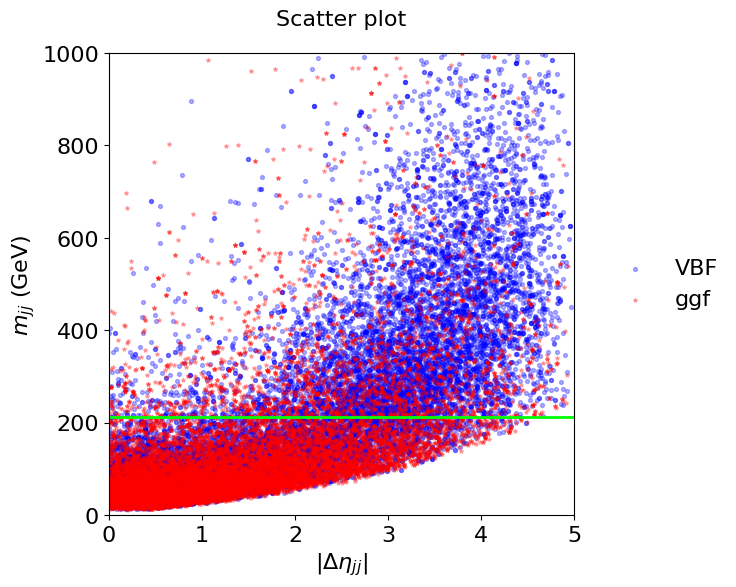

In [ ]:
plot_scatter(sig,bkg, boundary[1])